#  保险赔偿预测——XGBoost调参策略

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
# from sklearn.cross_validation import KFold, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

## 数据预处理

In [2]:
train = pd.read_csv('dataset/train.csv')

做loss列的对数变换

In [3]:
train['log_loss'] = np.log(train['loss'])

数据分成连续和离散特征

In [4]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


And use a label encoder for categorical features:

In [5]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


## Simple XGBoost Model

首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差MAE来衡量

mean_absolute_error(np.exp(y), np.exp(yhat))。


xgboost 自定义了一个数据矩阵类 DMatrix，会在训练开始时进行一遍预处理，从而提高之后每次迭代的效率

In [6]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

### Model

In [7]:
#把x和y传进去。使用ndarry结构或者DataFrame结构也可以建模，但不如XGB模型定义的数据底层格式DMatrix效率高。
dtrain = xgb.DMatrix(train_x, train['log_loss'])    

## Xgboost参数
- 'booster':'gbtree',
- 'objective': 'multi:softmax', 多分类的问题
- 'num_class':10, 类别数，与 multisoftmax 并用
- 'gamma':损失下降多少才进行分裂
- 'max_depth':12, 构建树的深度，越大越容易过拟合
- 'lambda':2,  控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
- 'subsample':0.7, 随机采样训练样本
- 'colsample_bytree':0.7, 生成树时进行的列采样
- 'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
- 'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
- 'eta': 0.007, 学习率，但不同于梯度下降的学习率——每新加入一棵树，在预测输出中占比达到多少
- 'seed':1000,
- 'nthread':7, cpu 线程数

In [8]:
#先随便选择一组参数
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

XGBoost中集成了一个交叉验证、找最佳参数模块 `xgb.cv` 

In [9]:
%%time
      
#feval设置评价采用mae---CVscore
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

[11:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

我们得到了第一个基准结果：MAE＝1218.9

<Figure size 432x288 with 0 Axes>

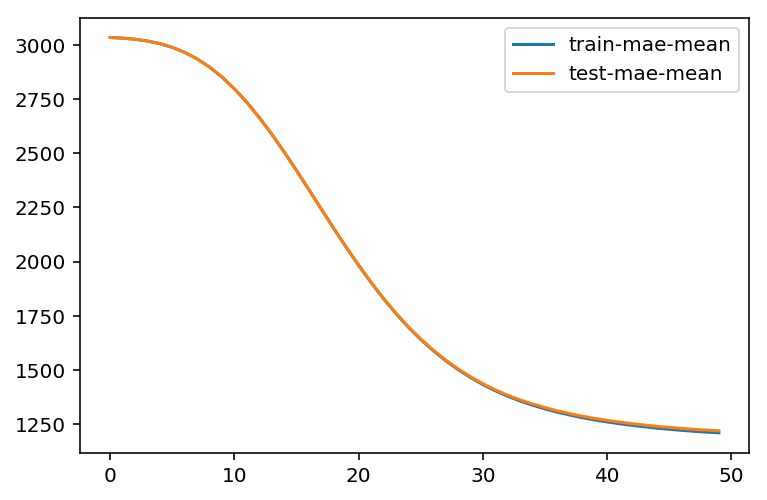

In [10]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()    #train和test基本叠加在一起——表示没有出现过拟合

### 如上是我们的第一个基础模型：

* 没有发生过拟合
* 只建立了50个树模型
* 接下来改一下树模型的个数，看对结果的影响。


In [11]:
%%time
#建立100个树的模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

[11:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

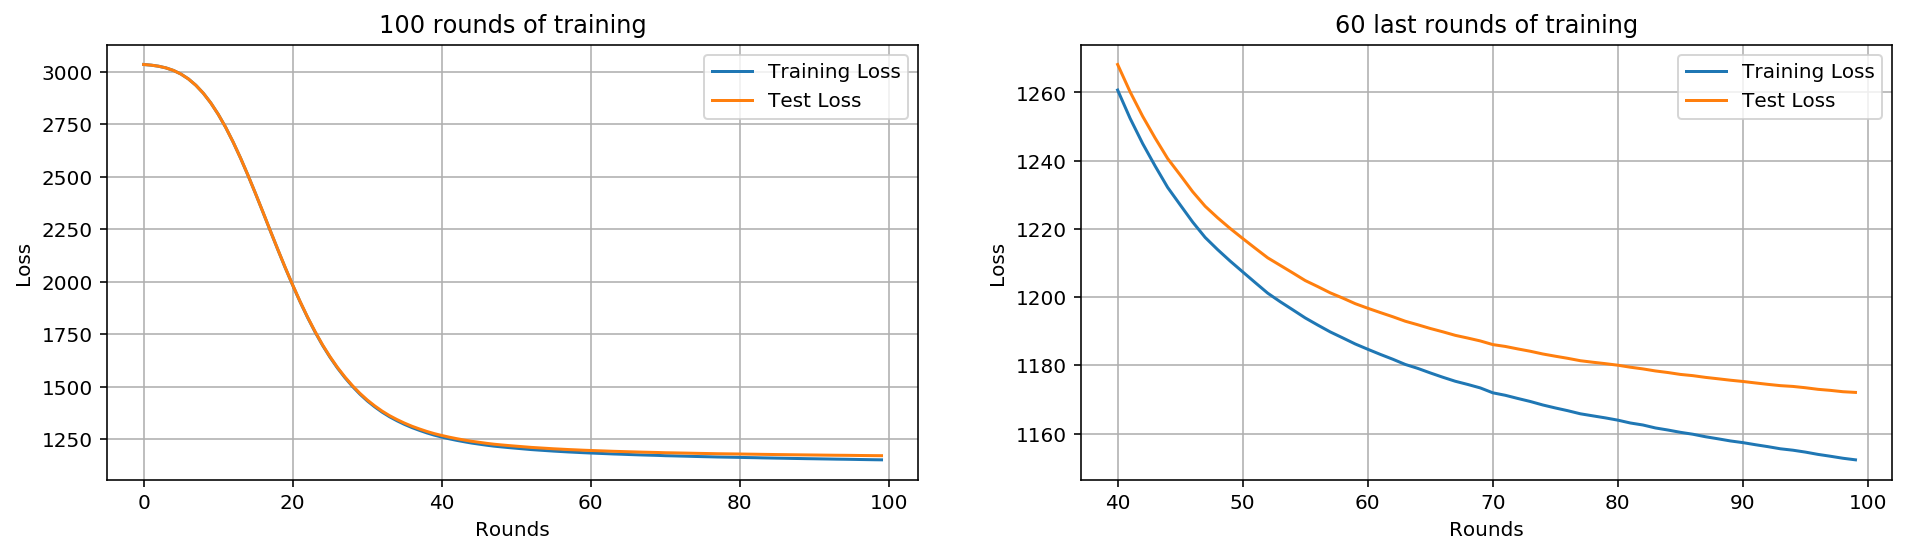

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

左图采用100棵树，输入结果两条线基本吻合，没有过拟合。    其中的后60次单独拿出来作图，发现其中有点过拟合——测试效果没有训练效果好

我们得到了新的纪录 **MAE = 1171.77** 比第一次的要好 (1218.9)。接下来我们要改变其他参数，看这些参数对结果的影响。

## XGBoost 参数调节

* Step 1: 选择一组初始参数


* Step 2: 改变 `max_depth` 和 `min_child_weight`.


* Step 3: 调节 `gamma` 降低模型过拟合风险.


* Step 4: 调节 `subsample` 和 `colsample_bytree` 改变数据采样策略.


* Step 5: 调节学习率 `eta`.

In [13]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [14]:
#制定几个衡量标准
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [15]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

In [16]:
bst.kfold(train_x, train_y, nfold=5)

[11:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

train-rmse-mean       0.558937
train-rmse-std        0.001005
test-rmse-mean        0.562665
test-rmse-std         0.002445
train-mae-mean     1209.707324
train-mae-std         3.004207
test-mae-mean      1218.884204
test-mae-std          8.982969
Name: 49, dtype: float64

### Step 1: 基准模型

### Step 2: 树的深度与节点权重

这些参数对xgboost性能影响最大，因此，他们应该调整第一。我们简要地概述它们：


* `max_depth`: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。

* `min_child_weight`: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。

In [17]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [18]:
%%time

#网格搜索参数优化
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[11:52:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:52:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:52:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { num_boost_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x00000230801384E0>,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [19]:
grid.grid_scores_, grid.best_params_, grid.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

网格搜索发现的最佳结果:

`{'max_depth': 8, 'min_child_weight': 6},
 -1187.9597499123447)`
 
设置成负的值是因为要找大的值


In [ ]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i)
        _params_mae.append(i)
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [ ]:
_,scores =  convert_grid_scores(grid.cv_results_['mean_test_score'])
scores = scores.reshape(5,3)

In [ ]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

#当前结果输出——热度图形式——绿色最重的这部分对应的损失值最小

我们看到，从网格搜索的结果，分数的提高主要是基于max_depth增加.
min_child_weight稍有影响的成绩，但是，我们看到，min_child_weight = 6会更好一些。

### Step 3: 调节 gamma去降低过拟合风险

In [ ]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

我们选择使用偏小一些的 `gamma`.

### Step 4: 调节样本采样方式 subsample 和 colsample_bytree

In [ ]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

在当前的预训练模式的具体案例，我得到了下面的结果：

`{'colsample_bytree': 0.8, 'subsample': 0.8},   这个效果最好
 -1182.9309918891634)

### Step 5: 减小学习率并增大树个数

参数优化的最后一步是降低学习速度，同时增加更多的估计量

First, we plot different learning rates for a simpler model (50 trees):

In [ ]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}   #取了一堆学习率的参数值
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

#50个树的模型下，随着学习率的改变。。。

`{'eta': 0.2}, -1160.9736284869114` 是目前最好的结果

现在我们把树的个数增加到100

In [ ]:

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

学习率低一些的效果更好

In [ ]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

再增加树的个数呢？

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [ ]:
%%time

# Final XGBoost model   最终确定的XGBoost模型


bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

In [ ]:
cv

我们看到200棵树最好的ETA是0.07。

这样我们花了相当长的一段时间优化xgboost. 从初始值: **1219.57**. 经过调参之后，


* 100 trees, `eta=0.1`: **MAE=1152.247**
* 200 trees, `eta=0.07`: **MAE=1145.92**    这是目前最低的MAE，此时所得模型如下


`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.07).

 调参对于性能有一定的改进，但不大；除了调参手段之外，特征工程对于模型效果而言更为重要。